
# Tests for ParallelCondensedMSTBoruvka

Notebook pour valider la génération de graphes et l'utilisation de `ParallelCondensedMSTBoruvka`.


In [1]:
%%bash
git clone https://github.com/Ludwig-H/ParallelCondensedMSTBoruvka.git
cd ParallelCondensedMSTBoruvka
pip install .

Processing /content/ParallelCondensedMSTBoruvka
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for ParallelCondensedMSTBoruvka: filename=parallelcondensedmstboruvka-0.3.0-cp312-cp312-linux_x86_64.whl size=663459 sha256=c8f356df0620bd40b912c44725cbc133e7106c42028ddb89957a8632df25446c
  Stored in directory: /tmp/pip-ephem-wheel-cache-_fgi08u1/wheels/0e/9d/9f/be7295557551cf67c1b10ded20c3034c26b662ddc8c5199f5c
Successfully built ParallelCondensedMSTBoruvka


Cloning into 'ParallelCondensedMSTBoruvka'...


In [2]:
# import importlib
# import pathlib
# import subprocess
# import sys

# ROOT = pathlib.Path.cwd()
# SRC = ROOT / "src"
# if str(SRC) not in sys.path:
#     sys.path.insert(0, str(SRC))

import matplotlib  # noqa: F401
import scipy  # noqa: F401

import ParallelCondensedMSTBoruvka as parallel_condensed_mst_boruvka

# subprocess.check_call([sys.executable, "-m", "pip", "install", "-e", str(ROOT)])
# importlib.invalidate_caches()
# importlib.import_module("parallel_condensed_mst_boruvka")


In [3]:
print('Environnement prêt.')

Environnement prêt.


In [4]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from itertools import combinations
from scipy.spatial import Delaunay

from parallel_condensed_mst_boruvka import ParallelCondensedMSTBoruvka, GetClusters

np.set_printoptions(precision=3, suppress=True)

def flatten_cluster_labels(raw_labels):
    labels = []
    for entry in raw_labels:
        if isinstance(entry, tuple):
            cid, _ = entry
            labels.append(int(cid) if cid != -1 else -1)
        elif isinstance(entry, list):
            if not entry:
                labels.append(-1)
            else:
                cid, weight = max(entry, key=lambda x: x[1])
                labels.append(int(cid) if cid != -1 else -1)
        else:
            val = int(entry)
            labels.append(val if val != -1 else -1)
    return np.asarray(labels, dtype=int)

def palette_from_labels(labels):
    unique = sorted(set(int(l) for l in labels), key=lambda x: (x == -1, x))
    cmap = plt.cm.get_cmap('tab20', max(len(unique) - (1 if -1 in unique else 0), 1))
    color_map = {}
    next_idx = 0
    for lab in unique:
        if lab == -1:
            color_map[lab] = (0.6, 0.6, 0.6, 1.0)
        else:
            color_map[lab] = cmap(next_idx)
            next_idx += 1
    color_values = np.asarray([color_map[int(lab)] for lab in labels])
    return color_values, color_map

def triangle_miniball_radius(tri_points):
    a = float(np.linalg.norm(tri_points[1] - tri_points[0]))
    b = float(np.linalg.norm(tri_points[2] - tri_points[0]))
    c = float(np.linalg.norm(tri_points[2] - tri_points[1]))
    lengths = np.asarray([a, b, c])
    longest = lengths.max()
    sq = lengths ** 2
    if (sq[0] >= sq[1] + sq[2]) or (sq[1] >= sq[0] + sq[2]) or (sq[2] >= sq[0] + sq[1]):
        return longest / 2.0
    area = 0.5 * abs(np.cross(tri_points[1] - tri_points[0], tri_points[2] - tri_points[0]))
    if area < 1e-12:
        return longest / 2.0
    return (a * b * c) / (4.0 * area)


In [5]:

rng = np.random.default_rng(12345)
n = 200
k = 5
centers = rng.uniform(-5.0, 5.0, size=(k, 2))
scales = rng.uniform(0.2, 0.8, size=k)
covs = np.array([[[s, 0.0], [0.0, s]] for s in scales])
weights = rng.dirichlet(np.ones(k))
assignments = rng.choice(k, size=n, p=weights)
points = np.vstack([rng.multivariate_normal(centers[c], covs[c]) for c in assignments])

tri = Delaunay(points)
simplices = tri.simplices

edge_lengths = {}
for simplex in simplices:
    simplex = np.sort(simplex)
    for a in range(3):
        for b in range(a + 1, 3):
            i = int(simplex[a]); j = int(simplex[b])
            key = (i, j) if i < j else (j, i)
            if key not in edge_lengths:
                edge_lengths[key] = float(np.linalg.norm(points[key[0]] - points[key[1]]))

edge_items = sorted(edge_lengths.items())
N_edges = len(edge_items)
U_e = np.asarray([edge[0] for edge, _ in edge_items], dtype=np.int32)
V_e = np.asarray([edge[1] for edge, _ in edge_items], dtype=np.int32)
W_e = np.asarray([dist for _, dist in edge_items], dtype=np.float64)

edge_index = {edge: idx for idx, (edge, _) in enumerate(edge_items)}
edges_by_point = {i: [] for i in range(n)}
for idx, (edge, _) in enumerate(edge_items):
    u, v = edge
    edges_by_point[u].append(idx)
    edges_by_point[v].append(idx)

Points_e = [[(i, 1.0)] for i in range(n)]

print(f"Nombre de points: {n}")
print(f"Nombre d'arêtes de Delaunay: {N_edges}")


Nombre de points: 200
Nombre d'arêtes de Delaunay: 586


Clusters (graphe des points):
  bruit: 158 points
  cluster 2: 42 points


/tmp/ipython-input-1728148463.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', max(len(unique) - (1 if -1 in unique else 0), 1))


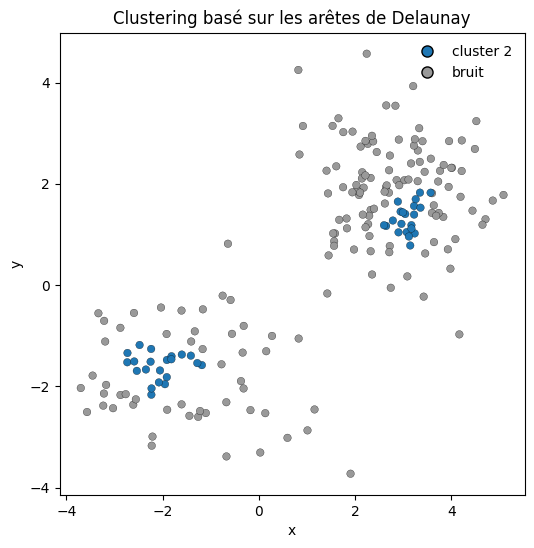

In [16]:

min_cluster_size = 15
N_CPU_dispos = 8
splitting = None # lambda x : 1
verbose = True

Z_e, Edges_e = ParallelCondensedMSTBoruvka(n, U_e, V_e, W_e, Points_e, min_cluster_size, N_CPU_dispos, verbose)
raw_labels_e = GetClusters(Z_e, Edges_e, U_e, V_e, 'eom', Points_e, N_CPU_dispos, splitting, verbose)
labels_e = flatten_cluster_labels(raw_labels_e)
unique_e, counts_e = np.unique(labels_e, return_counts=True)
print('Clusters (graphe des points):')
for lab, cnt in zip(unique_e, counts_e):
    name = 'bruit' if lab == -1 else f'cluster {lab}'
    print(f"  {name}: {cnt} points")

color_values_e, color_map_e = palette_from_labels(labels_e)
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(points[:, 0], points[:, 1], c=color_values_e, s=30, edgecolor='black', linewidth=0.2)
ax.set_title('Clustering basé sur les arêtes de Delaunay')
ax.set_xlabel('x')
ax.set_ylabel('y')
handles = []
for lab, color in color_map_e.items():
    label = 'bruit' if lab == -1 else f'cluster {lab}'
    handles.append(Line2D([0], [0], marker='o', linestyle='None', markerfacecolor=color, markeredgecolor='black', markersize=8, label=label))
ax.legend(handles=handles, loc='best', frameon=False)
plt.show()


In [7]:
Z_e

array([[  1.   ,   5.   ,   0.21 ,  20.   ,   6.618],
       [  8.   ,  13.   ,   0.231,  10.   ,   0.181],
       [ 19.   ,  20.   ,   0.231,  32.   ,   2.304],
       [ 12.   ,  21.   ,   0.235,  39.   ,   2.878],
       [  3.   ,  22.   ,   0.242,  46.   ,   7.504],
       [  4.   ,  23.   ,   0.248,  53.   ,   6.374],
       [  6.   ,  10.   ,   0.252,  13.   ,  10.029],
       [ 25.   ,   7.   ,   0.26 ,  21.   ,   7.284],
       [  9.   ,  24.   ,   0.264,  61.   ,  34.769],
       [ 27.   ,   2.   ,   0.291,  68.   ,  14.755],
       [ 26.   ,  15.   ,   0.335,  32.   ,   9.993],
       [ 11.   ,  28.   ,   0.345,  85.   ,  10.328],
       [  0.   ,  30.   ,   0.364, 102.   ,  16.966],
       [ 14.   ,  29.   ,   0.443,  43.   ,   6.213],
       [ 17.   ,  32.   ,   0.477,  51.   ,   5.73 ],
       [ 18.   ,  33.   ,   0.496,  58.   ,   5.454],
       [ 16.   ,  34.   ,   0.515,  63.   ,  13.606],
       [ 35.   ,  31.   ,   1.071, 197.   ,   8.18 ]])

In [8]:
Edges_e

[[120, 187, 188, 189],
 [30, 224, 487, 488],
 [326, 328, 429, 491],
 [338, 359, 387, 513],
 [191, 192, 313, 315, 423],
 [272, 397, 398, 399],
 [149, 445, 446, 560],
 [273, 348, 349, 450, 558],
 [9, 11, 215, 259],
 [70, 74, 291, 516],
 [303, 329, 331, 354, 355, 495],
 [12, 14, 365, 427],
 [146, 317, 318, 391, 522, 538],
 [138, 140, 542, 543],
 [53, 58, 253, 417],
 [33, 127, 182, 184, 408, 551, 579],
 [41, 42, 324, 325],
 [21, 24, 79, 406],
 [66, 95, 267, 421],
 [90],
 [486],
 [219],
 [278],
 [107],
 [62],
 [227],
 [285],
 [567],
 [132],
 [60],
 [517],
 [212],
 [269],
 [4],
 [217],
 [254],
 [256]]

In [9]:
[len(e) for e in Edges_e]

[4,
 4,
 4,
 4,
 5,
 4,
 4,
 5,
 4,
 4,
 6,
 4,
 6,
 4,
 4,
 7,
 4,
 4,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [10]:
try:
    import hdbscan
except ModuleNotFoundError:
    !pip install hdbscan
    import hdbscan

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


Clusters (HDBSCAN):
  bruit: 3 points
  cluster 0: 125 points
  cluster 1: 72 points


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/tmp/ipython-input-1728148463.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', max(len(unique) - (1 if -1 in unique else 0), 1))


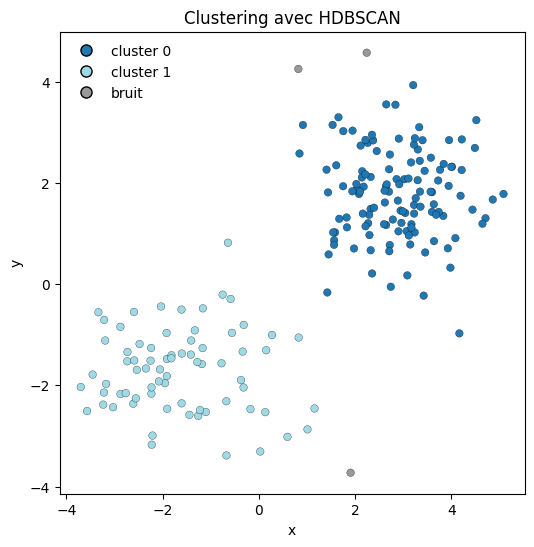

In [11]:
min_cluster_size_hdbscan = 15
min_samples_hdbscan = 1

clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size_hdbscan, min_samples=min_samples_hdbscan)
labels_hdbscan = clusterer.fit_predict(points)

unique_hdbscan, counts_hdbscan = np.unique(labels_hdbscan, return_counts=True)
print('Clusters (HDBSCAN):')
for lab, cnt in zip(unique_hdbscan, counts_hdbscan):
    name = 'bruit' if lab == -1 else f'cluster {lab}'
    print(f"  {name}: {cnt} points")

color_values_hdbscan, color_map_hdbscan = palette_from_labels(labels_hdbscan)
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(points[:, 0], points[:, 1], c=color_values_hdbscan, s=30, edgecolor='black', linewidth=0.2)
ax.set_title('Clustering avec HDBSCAN')
ax.set_xlabel('x')
ax.set_ylabel('y')
handles = []
for lab, color in color_map_hdbscan.items():
    label = 'bruit' if lab == -1 else f'cluster {lab}'
    handles.append(Line2D([0], [0], marker='o', linestyle='None', markerfacecolor=color, markeredgecolor='black', markersize=8, label=label))
ax.legend(handles=handles, loc='best', frameon=False)
plt.show()

In [12]:

edge_edge_weights = {}
for simplex in simplices:
    simplex = np.sort(simplex)
    eids = []
    for a in range(3):
        for b in range(a + 1, 3):
            i = int(simplex[a]); j = int(simplex[b])
            key = (i, j) if i < j else (j, i)
            eids.append(edge_index[key])
    radius = triangle_miniball_radius(points[simplex])
    for e1, e2 in combinations(eids, 2):
        key = (e1, e2) if e1 < e2 else (e2, e1)
        current = edge_edge_weights.get(key)
        if current is None or radius < current:
            edge_edge_weights[key] = float(radius)

edge_edge_items = sorted(edge_edge_weights.items())
U_t = np.asarray([edge[0] for edge, _ in edge_edge_items], dtype=np.int32)
V_t = np.asarray([edge[1] for edge, _ in edge_edge_items], dtype=np.int32)
W_t = np.asarray([w for _, w in edge_edge_items], dtype=np.float64)

Points_t = []
for i in range(n):
    eids = edges_by_point[i]
    if eids:
        weight = 1.0 / len(eids)
        Points_t.append([(int(e), float(weight)) for e in eids])
    else:
        Points_t.append([])




/tmp/ipython-input-1728148463.py:51: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  area = 0.5 * abs(np.cross(tri_points[1] - tri_points[0], tri_points[2] - tri_points[0]))


/tmp/ipython-input-1728148463.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', max(len(unique) - (1 if -1 in unique else 0), 1))


Clusters (graphe des arêtes via triangles):
  bruit: 157 points
  cluster 12: 43 points


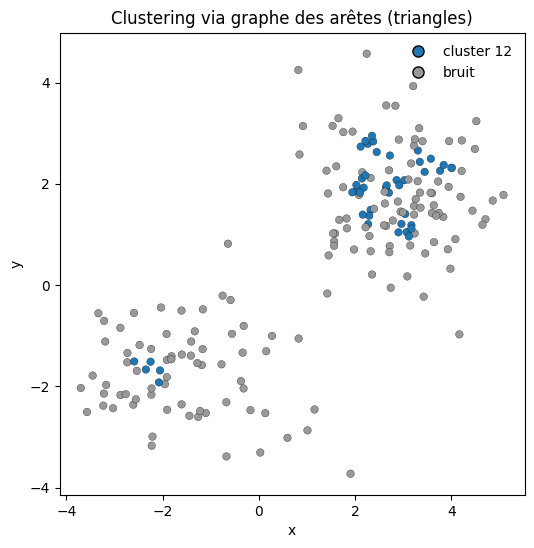

In [13]:
Z_t, Edges_t = ParallelCondensedMSTBoruvka(N_edges, U_t, V_t, W_t, Points_t, min_cluster_size, N_CPU_dispos, verbose)
raw_labels_t = GetClusters(Z_t, Edges_t, U_t, V_t, 'eom', Points_t, N_CPU_dispos, splitting, verbose)
labels_t = flatten_cluster_labels(raw_labels_t)
unique_t, counts_t = np.unique(labels_t, return_counts=True)
print('Clusters (graphe des arêtes via triangles):')
for lab, cnt in zip(unique_t, counts_t):
    name = 'bruit' if lab == -1 else f'cluster {lab}'
    print(f"  {name}: {cnt} points")

color_values_t, color_map_t = palette_from_labels(labels_t)
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(points[:, 0], points[:, 1], c=color_values_t, s=30, edgecolor='black', linewidth=0.2)
ax.set_title('Clustering via graphe des arêtes (triangles)')
ax.set_xlabel('x')
ax.set_ylabel('y')
handles = []
for lab, color in color_map_t.items():
    label = 'bruit' if lab == -1 else f'cluster {lab}'
    handles.append(Line2D([0], [0], marker='o', linestyle='None', markerfacecolor=color, markeredgecolor='black', markersize=8, label=label))
ax.legend(handles=handles, loc='best', frameon=False)
plt.show()

In [14]:
Z_t

array([[  2.   ,   1.   ,   0.182,  24.894,   0.442],
       [  7.   ,   4.   ,   0.184,  40.82 ,   3.473],
       [  5.   ,   8.   ,   0.2  ,  49.914,   2.201],
       [  0.   ,   9.   ,   0.215,  61.811,   0.531],
       [  6.   ,  10.   ,   0.247,  85.302,   7.224],
       [ 11.   ,   3.   ,   1.08 , 195.327,  16.132]])

In [15]:
Edges_t

[[252,
  253,
  254,
  255,
  256,
  258,
  259,
  261,
  289,
  291,
  333,
  334,
  335,
  336,
  505,
  746,
  747],
 [76, 78, 86, 92, 94, 576, 577, 578, 580, 702, 703, 1075, 1076, 1077],
 [24, 26, 28, 30, 388, 390, 391, 393, 567, 568, 834, 835, 1131, 1132],
 [693,
  695,
  752,
  753,
  757,
  759,
  846,
  847,
  848,
  849,
  851,
  853,
  1016,
  1017,
  1018,
  1020,
  1024,
  1026,
  1149,
  1150],
 [212,
  214,
  474,
  475,
  476,
  477,
  478,
  479,
  482,
  484,
  727,
  729,
  784,
  786,
  921,
  922,
  923],
 [507, 509, 510, 511, 513, 514, 515, 516, 517, 777, 778, 779, 780],
 [8, 9, 10, 12, 14, 15, 17, 801, 802, 803, 804, 982, 984, 1056, 1080, 1081],
 [589, 590],
 [373, 375],
 [177],
 [187],
 [561, 562],
 [286]]